In [11]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import gzip
import math
import numpy as np
from collections import Counter
from scipy import stats
from sklearn.linear_model import LinearRegression
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Parse careers

In [3]:
def get_year(year):

    if len(year) == 4: return int(year)
    else: return int(year.split('-')[0])


def get_career_data(dirid):
    
    x = []
    y = []


    for line in gzip.open('simple-careers/film-director-simple-careers/' + dirid + '_director_simple_career.gz'): 
    
        if 'year' not in line:
            fields = line.strip().split()
            
            if len( fields[1] ) > 0:
                    
                year = get_year(fields[1])
                if 'None' != fields[3]:

                    year   = float(get_year(fields[1]))
                    impact = float(fields[3])

                    x.append(year)
                    y.append(impact)

    if len(x) > 0:
        y, x = zip(*sorted([ (y[ijk], x[ijk]) for ijk in range(len(x)) ], key=lambda tup: tup[1]))        
    
        return max(y), len(y), max(x)-min(x)
    
    else:
        return 0, 0, 0, 0
    
    
get_career_data('nm0000184')


(938781.0, 17, 40.0)

# Get sucess features

In [4]:
def add_df_meas(meas, tipus):

    df = pd.DataFrame(meas.items(), columns = ['name', tipus])
    df.index = df.name
    df = df.drop(columns = ['name'])    
    
    return df


success = pd.DataFrame()
df_altmeasures = pd.DataFrame.from_csv('ALT_success_measures.csv', sep ='\t')

directors, best  = zip(*[line.strip().split('\t') for line in open('directors_Imax.dat')])
success          = add_df_meas({directors[i] : float(best[i]) for i in range(len(best))}, 'maxI')
directorss, summ = zip(*[line.strip().split('\t') for line in open('directors_Isum.dat')])
directors_sum    = add_df_meas({directorss[i] : float(summ[i]) for i in range(len(summ))}, 'sumI')
directorsss, Q   = zip(*[line.strip().split('\t') for line in open('../QMODELNEW/pQData/Q_distribution_director-10_0.dat')])
directors_Q      = add_df_meas({directorsss[i] : float(Q[i]) for i in range(len(Q))}, 'Q')


correl = pd.DataFrame.from_csv('NEWTemporal/3_corr_shift_QEVER.dat', sep ='\t', header = None)
correl = correl.rename(columns = {0 : 'name', 1 : 'taumax', 2 : 'correl', 3 : 'prod'})
correl.index.name = 'name'


success = success.merge(directors_sum,  left_index=True,  right_index=True)
success = success.merge(directors_Q,    left_index=True,  right_index=True)
success = success.merge(df_altmeasures, left_index=True,  right_index=True)
success = success.merge(correl, left_index=True,  right_index=True)
success = success.drop(columns = ['sumI', 'max_crit', 'max_gross', 'max_opening', 'sum_opening'])
success.head()


'''  WE DONT NEED ALL THESE FEATURES     '''
'''  SUMI AND OTHERS ARE MISSING THOUGH  '''
'''  PRODUCITIVITY?!?!?!                 '''
'''  DOUBLE CHECK REGRESSION             '''
'''  DO STUFF FOR ALL THE DIFFERENT REGR VERSIONS '''
'''  SLEEPING BEAUTY TIME?'''
'''  FIRST FIVE NETWORK MEASURES VALUE '''
'''  get the success params of all/first 5 collaborators '''

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()
/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


'  FIRST FIVE NETWORK MEASURES VALUE '

# Collaborators

# Get director IDs for filtering

In [6]:
'''measures     = ['degree', 'clustering', 'pagerank', 'betweenness', 'constraint']  
networker_id = {}

for meas in measures:
    
    if 2 == 2:
    #if meas == '':

        for line in open('NEWTemporal/3_corr_shift_'+meas+'_QEVER.dat'):
            imdb, tau, _, _ = line.strip().split('\t')
            tau = float(tau)

            if tau < 0:
                networker_id[imdb] = True
            elif tau > 0:
                networker_id[imdb] = False
   
print len(networker_id)
'''


measures = ['degree',    'clustering', 'pagerank', 'betweenness', 'constraint']  
ids_meas = {}
for meas in measures:


    for line in open('NEWTemporal/3_corr_shift_'+meas+'_QEVER.dat'):
        imdb, tau, _, _ = line.strip().split('\t')
        tau = float(tau)

        if imdb not in ids_meas:
            ids_meas[imdb] = np.sign(tau)
        else:
            ids_meas[imdb] += np.sign(tau)
        


directors = {imdbid : cnt for imdbid, cnt in ids_meas.items() if abs(cnt) >4}
Counter(ids_meas.values())
len(directors)

320

# Features' distributions


In [47]:
networkers    = {}
nonnetworkers = {}

networkers['Istar'] = []
networkers['N']     = []
networkers['T']     = []
networkers['id']    = []


nonnetworkers['Istar'] = []
nonnetworkers['N']     = []
nonnetworkers['T']     = []
nonnetworkers['id']    = []


#for dirid, networker in networker_id.items():
for dirid, tausign in directors.items():
 
    
    Istar, N, T = get_career_data(dirid)
    
    if tausign < 0: 
        networkers['Istar'].append(Istar)
        networkers['N'].append(N)
        networkers['T'].append(T)
        networkers['id'].append(dirid)
    else:
        nonnetworkers['Istar'].append(Istar)
        nonnetworkers['N'].append(N)
        nonnetworkers['T'].append(T)
        nonnetworkers['id'].append(dirid)

        
        
df_net = pd.DataFrame.from_dict(networkers)
df_net = df_net.set_index('id')
df_net['networker'] = 1
#df_net['aaa'] = random.randint(5,21)


df_non = pd.DataFrame.from_dict(nonnetworkers)
df_non = df_non.set_index('id')
df_non['networker'] = 0
#df_non['aaa'] = random.randint(0,15)

df_net = df_net.sample(len(df_non))
print len(df_net), len(df_non)

df = df_net.append(df_non)

# success = success.merge(directors_sum,  left_index=True,  right_index=True)

df = df.merge(success,  left_index=True,  right_index=True)
df = df.dropna()
df = df.drop(columns = ['taumax'])
df.head()        
        
if not os.path.exists('NetworkersAnalysis'):
    os.makedirs('NetworkersAnalysis')
df.to_csv('NetworkersAnalysis/directors_features.csv')

89 89


# Compare distributions

In [12]:
df = pd.DataFrame.from_csv('NetworkersAnalysis/directors_features.csv')
df.head()

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,Istar,N,T,networker,maxI,Q,meta_avg,sum_crit,sum_gross,correl,prod
nm0284638,71.0,17,28.0,1,71.0,15.231634,0.0,2.0,0.0,0.542208,12
nm0411208,1215.0,101,60.0,1,1215.0,73.285485,0.0,24.0,0.0,0.279750,39
nm0287988,2850.0,55,57.0,1,2850.0,95.128343,0.0,180.0,0.0,0.245570,47
nm0806252,15852.0,21,16.0,1,15852.0,473.348950,0.0,117.0,0.0,0.433342,17
nm0411030,783.0,90,44.0,1,783.0,33.572737,0.0,281.0,0.0,0.754879,16


(0, 0) Istar
Istar 0.139240506329114 0.40070620689042763
(0, 1) N
N 0.12658227848101267 0.5232034912257082
(0, 2) T
T 0.16216216216216217 0.26070053176269586
['Istar', 'N', 'T']


,Istar,N,T
KS,0.139241,0.126582,0.162162
p,0.400706,0.523203,0.260701


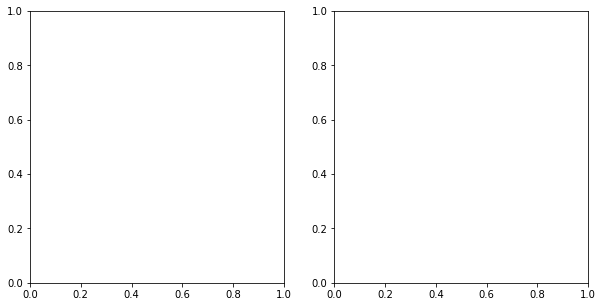

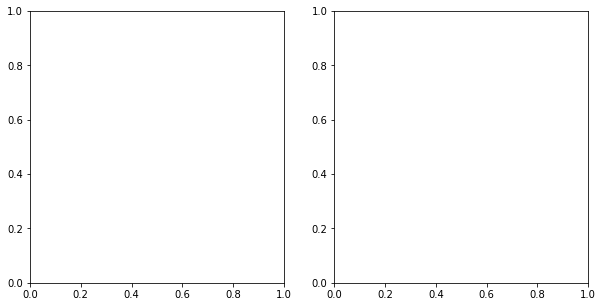

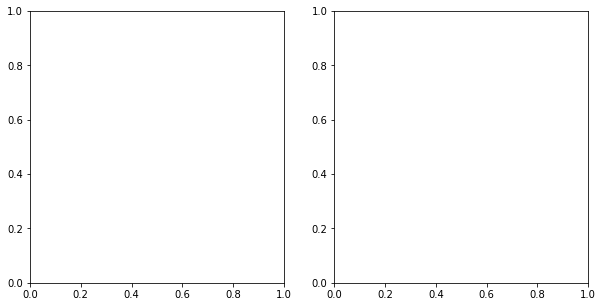

In [90]:


df_0  = df[df.networker == 0]
df_1  = df[df.networker == 1]
feats = list(df.keys())


outfolder = 'NetworkersAnalysis/DistributionPlots'
if not os.path.exists(outfolder):
    os.makedirs(outfolder)

res = {}  

    
for ind, feat in enumerate(feats[0:3]):

    print indicies[ind], feat

    x0 = df_0[feat]
    x1 = df_1[feat]
    
    if 'meta' in feat:
        x0 = [xx for xx in x0  if xx > 0]
        x1 = [xx for xx in x1  if xx > 0]
        
    if 'T' == feat:  
        x0 = [xx for xx in x0  if xx < 100]
        x1 = [xx for xx in x1  if xx < 100]        

    
    KS, p = stats.ks_2samp(x0, x1)
    f, ax = plt.subplots(1,2,figsize = (10,5))

    res[KS] = p
    
    print feat, KS, p
    
    '''plt.suptitle(feat + ', KS = ' + str(round(KS,3)), fontsize = 15 )
    
    ax[0].hist(x0, alpha = 0.6, bins = 15, density = True)#, cumulative = True)
    ax[0].hist(x1, alpha = 0.6, bins = 15, density = True)#, cumulative = True)

    ax[1].hist(x0, alpha = 0.6, bins = 15, density = True, cumulative = True)
    ax[1].hist(x1, alpha = 0.6, bins = 15, density = True, cumulative = True)
    
    plt.savefig(outfolder + '/' + feat + '.png')
    '''
 

    
#&for feat in feats

'''for k, v in data.items():                  


    if 'nm' not in str(v[0]):

        if ind == 1:
            ax[ind].set_title(k, fontsize = 17)
            v = [vv for vv in v if vv < 100]
        else:    
            ax[ind].set_title('log ' + k, fontsize = 17)
            v = [math.log(vv) for vv in v]

        print tats.ks_2samp(np.cumsum(p_rand), np.cumsum()) 

        ax[ind].hist(v, alpha = 0.6, bins = 15, density = True)
        #ax[ind].set_yscale('log')
        ind += 1

'''

print feats[0:3]
dfres = pd.DataFrame(res.items()).T
dfres = dfres.rename(columns = {ind : f for ind, f in enumerate(feats[0:3])})
dfres.index = ['KS', 'p']
dfres

# Features

# Classification

In [58]:
def balance_samples(data):
    
    data_0 = data[data.networker == 0]
    data_1 = data[data.networker == 1]
    
    num    = min([len(data_0), len(data_1)])
    data_0 = data_0.sample(num)
    data_1 = data_1.sample(num)
    
    return data_0.append(data_1)
    
   

def xgb_cl(X, y, Nest, CV, max_depth_ ,learning_rate_, subsample_):
      
    accuracies = []
        
    for i in range(Nest):

        train_data, test_data, train_label, test_label =  train_test_split(X, y, test_size=.33, random_state=42)    
          
        model2       = xgb.XGBClassifier(n_estimators=Nest   , max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
        train_model2 = model2.fit(train_data, train_label)
        pred2        = train_model2.predict(test_data)
        accuracies   += list(cross_val_score(train_model2, train_data, train_label, cv=CV))    

    return np.mean(accuracies), np.std(accuracies), len(X)



def NB_cl(X, y, Nest, CV):
    
    accuracies = []

    for i in range(Nest):

        train_data, test_data, train_label, test_label =  train_test_split(X, y, test_size=.33, random_state=42)    

        name       = 'Naive Bayes' 
        classifier = GaussianNB()  
        clas       = classifier.fit(train_data, train_label)
        accuracies += list(cross_val_score(clas, train_data, train_label, cv=CV))       
            
    return np.mean(accuracies), np.std(accuracies), len(X)



Nest = 1
CV   = 5


df = pd.DataFrame.from_csv('NetworkersAnalysis/directors_features.csv')

df = balance_samples(df)
X  = df.drop(columns =  ['networker'])
y  = df['networker']


print NB_cl(X, y, Nest, CV)
print xgb_cl(X, y, Nest, CV, 6 ,0.1, 0.8)

(0.45714285714285713, 0.06966066113489426, 158)
(0.45532467532467535, 0.10520189525925883, 158)


/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


# Matching samples

In [354]:
def get_propensity_score_bins(ddf, nbins, outcome):

    classifier = LogisticRegression(C=1.0, penalty='l1')

    #encode_cats(df_field, 'gender')
    #encode_cats(df_field, 'location')
    
    try:
        XL = ddf.drop(columns = ['networker', outcome, 'propensity', 'bins'])  
    except:
        XL = ddf.drop(columns = ['networker', outcome])  

        
    XL = StandardScaler().fit_transform(XL)
    XL = preprocessing.quantile_transform(XL, output_distribution = 'normal')
    yL = np.asarray(ddf['networker'])

    classifier.fit(XL, yL)
    yL_pred_cl   = classifier.predict(XL)
    yL_pred_prob = classifier.predict_proba(XL)


    df_prop = pd.DataFrame(ddf)
    df_prop['propensity'] = [p[1] for p in yL_pred_prob]
    

    df_prop['bins'] = pd.qcut(df_prop['propensity'], nbins, ['q' + str(i+1) for i in range(nbins)])
    df_prop.head()
    
    return df_prop, list(set(df_prop.bins))
   
    
    
    
def plot_distr(df_prop, labels, outcome, nbins):

    f, ax = plt.subplots(1,1,figsize = (15,6))

    for q in labels:

        df_filtered   = df_prop[df_prop.bins == q]
        df_filtered_nw = df_filtered[df_filtered.networker == 1]
        df_filtered_nn = df_filtered[df_filtered.networker == 0]

        netws    = list(df_filtered_nw[outcome]) 
        nonnetws = list(df_filtered_nn[outcome])
        
        mcounts, mbins, bars = ax.hist(netws, normed = True, bins = 10 ** np.linspace(np.log10(min(netws)), np.log10(max(netws)), nbins), alpha=0.0, cumulative=0)
        mbins = (mbins[1:] + mbins[:-1])/2


        fcounts, fbins, bars = ax.hist(nonnetws, normed = True, bins = 10 ** np.linspace(np.log10(min(nonnetws)), np.log10(max(nonnetws)), nbins), alpha=0.0, cumulative=0)
        fbins = (fbins[1:] + fbins[:-1])/2

        ax.plot(mbins, mcounts, 'o-', color = 'crimson')
        ax.plot(fbins, fcounts, 'o-', color = 'steelblue')

        ax.set_yscale('log')
        ax.set_xscale('log')
        
    ax.plot(mbins, mcounts, 'o-', linewidth = 0, color = 'crimson',  label = 'networkers')
    ax.plot(fbins, fcounts, 'o-', linewidth = 0, color = 'steelblue', label = 'non-networkers')    
        
    ax.legend(loc = 'best')    
    
    
    
def do_linear_regr(df_prop, labels, outcome): 

    regr      = LinearRegression()
    regr_data = {}
    df_res    = pd.DataFrame()

    for q in labels:

        df_q = df_prop[df_prop.bins == q]
        X_reg = df_q.drop(columns = ['bins', 'propensity', 'networker'])
        covs  = X_reg.keys()

        y_reg = df_q['networker']

        X_reg = StandardScaler().fit_transform(X_reg)
        X_reg = preprocessing.quantile_transform(X_reg, output_distribution = 'normal')

        y_reg = StandardScaler().fit_transform(np.asarray(y_reg).reshape(-1, 1) )
       # y_reg = preprocessing.quantile_transform(y_reg, output_distribution = 'normal')


        train_data, test_data, train_label, test_label =  train_test_split(X_reg, y_reg, test_size=.33, random_state=42)
        regr.fit(train_data, train_label)

        
        print regr.score(X_reg, y_reg)
     
        res = {}
        res['R^2 - train'] = r2_score(train_label, regr.predict(train_data))
        res['R^2 - test']  = r2_score(test_label, regr.predict(test_data))

        
        for i in range(len(covs)):
             res[covs[i]] = (regr.coef_[0][i],)
          
        
        res = pd.DataFrame(res)
        res.index = [q]
        res.index.name = 'quart'
        df_res = df_res.append(res)
        
        
    return df_res


outc = 'N'
df_prop, labels = get_propensity_score_bins(df, nbins = 5, outcome = outc)
print df_prop.keys()
#plot_distr(df_prop, labels, outc, 12)
res = do_linear_regr(df_prop, labels, outcome)


res

Index([u'Istar', u'N', u'T', u'networker', u'maxI', u'Q', u'meta_avg',
       u'sum_crit', u'sum_gross', u'correl', u'prod', u'propensity', u'bins'],
      dtype='object')
0.1404886751832295
-1.291038944871973
-0.4766780280519273
-6.233186096809432e+27
-2.3196746745433527


,Istar,N,Q,R^2 - test,R^2 - train,T,correl,maxI,meta_avg,prod,sum_crit,sum_gross
quart,,,,,,,,,,,,
q1,2.061716e-01,-0.187065,-0.011568,-5.151214e-01,0.479985,0.142268,-0.224000,2.061716e-01,0.223320,0.246980,-0.025240,-1.644983e-01
q3,1.300485e-01,0.129536,-0.723472,-4.506670e+00,0.480591,-0.336011,-0.055208,1.300485e-01,-1.265281,0.466220,-0.415160,1.578434e+00
q2,2.427512e-01,0.813038,-0.086835,-2.208031e+00,0.420870,-0.126226,-0.002570,2.427512e-01,0.538980,-0.988357,0.140118,-6.652341e-01
q5,1.089385e+12,-0.004883,0.214294,-1.737824e+28,0.220874,-0.008652,-0.113770,-1.089385e+12,-0.060791,-0.102631,0.481232,2.811788e+13
q4,-1.231791e-01,-0.010136,-0.086998,-6.893704e+00,0.429749,0.044643,-0.270366,-1.231791e-01,0.859474,-0.036048,0.455090,-1.274299e+00
